In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner
%matplotlib inline


D:\Anaconda\envs\tor1131py37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 生成回归数据集 加高斯噪声
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

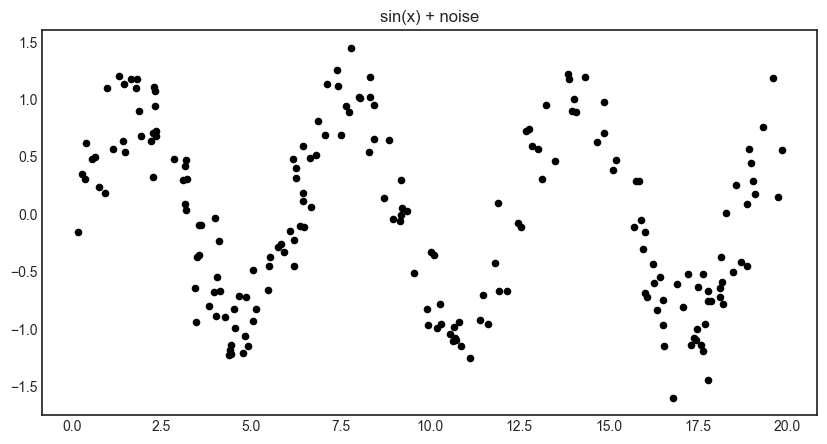

In [3]:
#原始数据集可视化
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, c='k', s=20)
    plt.title('sin(x) + noise')
    plt.show()

In [4]:
# 初始数据集的选取
n_initial = 5 # 最开始随机选取5个标注好的数据集进行训练
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

3.定义主动学习器ActiveLeaner
（参数包括模型的选取estimator、应用于请求标注的查询策略query_stategy以及初始数据）
我们使用高斯回归作为模型进行训练GaussianProcessRegressor

In [5]:
#定义estimator高斯回归模型的核函数
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))


In [6]:
#定义query_stategy应用于请求标注的查询策略
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True) #不确定度度量
    query_idx = np.argmax(std) #样本的选取
    return query_idx, X[query_idx]


In [7]:
#定义ActiveLeaner 主动学习器
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)


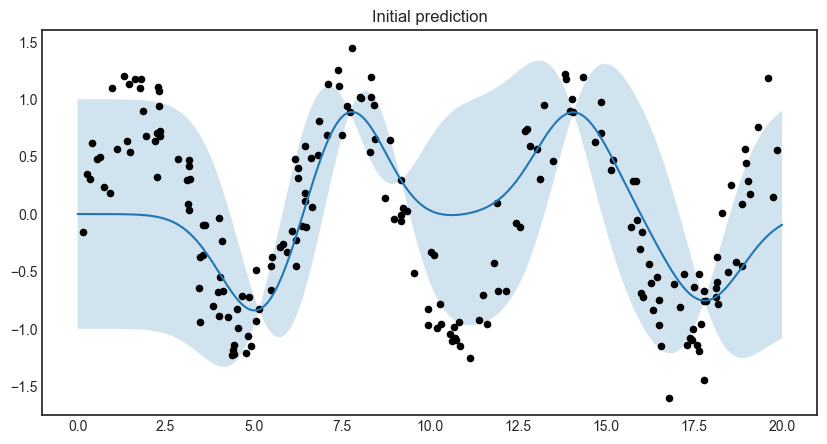

In [8]:
#可视化初始模型的精度状况
X_grid = np.linspace(0, 20, 1000)
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)    #
y_pred, y_std = y_pred.ravel(), y_std.ravel()
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X_grid, y_pred)
    plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Initial prediction')
    plt.show()


In [9]:
#定义n_queries（要标记数据的数量）进行主动学习
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))


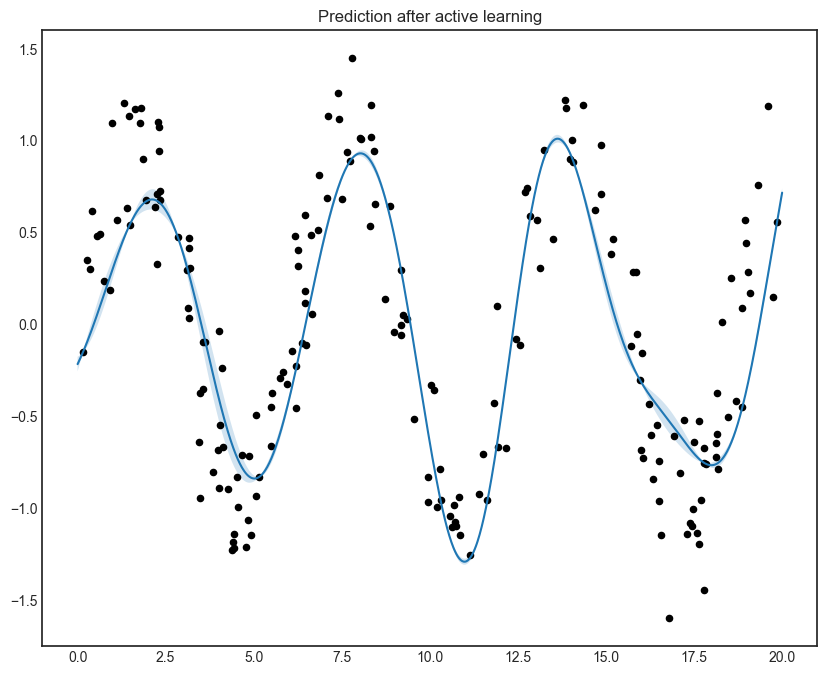

In [10]:
y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred_final)
    plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Prediction after active learning')
    plt.show()
